In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from tqdm import trange, tqdm

import sys
sys.path.append('../')
from CAS import *

In [31]:
def compute_edge_weights(G, cas, clusters, combine_function="min", normalize=True, eps=10**-5):
        source_to_target = np.empty(G.ecount())
        target_to_source = np.empty(G.ecount())
        for i, e in enumerate(G.es):
                target_clusters = clusters.indices[clusters.indptr[e.target]:clusters.indptr[e.target+1]]
                if len(target_clusters) == 0:
                        source_to_target[i] = 0
                else:
                        source_to_target[i] = np.max([cas[e.source, target_cluster] for target_cluster in target_clusters])

                source_clusters = clusters.indices[clusters.indptr[e.source]:clusters.indptr[e.source+1]]
                if len(source_clusters) == 0:
                        target_to_source[i] = 0
                else:
                        target_to_source[i] = np.max([cas[e.source, source_cluster] for source_cluster in source_clusters])

        if combine_function=="min":
                weights = np.minimum(source_to_target, target_to_source)
        elif combine_function=="prod":
               weights = source_to_target * target_to_source
        elif combine_function=="mean":
                weights = np.mean(np.stack(source_to_target, target_to_source), axis=1)
        else:
               raise ValueError(f"combine_function must be one of min, prod, mean. Got {combine_function}")
        
        if normalize:
               return weights / (np.max(weights) - np.min(weights) + eps)
        return weights


def cas_edge_weights(G, clusters, combine_function="min", normalize=True):
        graph_matrix = G.get_adjacency_sparse()
        ief, beta, c, p, degs = CAS(graph_matrix, clusters)

        ief_weights = compute_edge_weights(G, ief, clusters, combine_function=combine_function, normalize=normalize)
        beta_weights = compute_edge_weights(G, beta, clusters, combine_function=combine_function, normalize=normalize)
        c_weights = compute_edge_weights(G, c, clusters, combine_function=combine_function, normalize=normalize)
        p_weights = compute_edge_weights(G, p, clusters, combine_function=combine_function, normalize=normalize)
        
        return ief_weights, beta_weights, c_weights, p_weights


def ensemble_cas_edge_weights(G, ens_size=16, combine_function="min", normalize=True, clustering_method="leiden", resolution=0.1):
        ief_weights = np.zeros(G.ecount())
        beta_weights = np.zeros(G.ecount())
        c_weights = np.zeros(G.ecount())
        p_weights = np.zeros(G.ecount())

        for i in range(ens_size):
                permutation = np.random.permutation(G.vcount())
                g = G.permute_vertices(permutation)
                if clustering_method == "leiden":
                        clustering = np.array(g.community_leiden(resolution=resolution).membership)
                elif clustering_method == "louvain":
                        clustering = np.array(g.community_louvain(resolution=resolution).membership)
                elif clustering_method == "first_louvain":
                        clustering = np.array(g.community_multilevel(return_levels=True)[0].membership)
                else:
                        raise ValueError(f"clustering_method expected one of leiden, louvain, or first_louvain. Got {clustering_method}")
                
                clustering = partition2sparse(clustering)
                ief, beta, c, p = cas_edge_weights(g, clustering, combine_function=combine_function, normalize=normalize)

                ief_weights += ief
                beta_weights += beta
                c_weights += c
                p_weights += p

        return ief_weights/ens_size, beta_weights/ens_size, c_weights/ens_size, p_weights/ens_size


def cluster_edges(G, edge_weights, min_weight=0.05, twocore=True, final="leiden", resolution=1.0):
        if min_weight > 0:
                edge_weights = (1-min_weight) * edge_weights + np.full(len(edge_weights), min_weight)
        
        if twocore:
                core = G.shell_index()
                ecore = np.array([min(core[e.source],core[e.target]) for e in G.es])
                edge_weights[ecore == 1] = min_weight

        if final == "leiden":
                return G.community_leiden(weights=edge_weights, objective_function='modularity', resolution=resolution)
        elif final == "louvain":
                return G.community_multilevel(weights=edge_weights)
        else:
                raise ValueError(f"final expected one of leiden or louvain. Got {final}")

In [24]:
def community_ecg(self, weights=None, ens_size = 16, min_weight = 0.05, 
                  final='louvain', resolution=1.0, refuse_score=False):
    """
    Stable ensemble-based graph clustering;
    the ensemble consists of single-level randomized Louvain; 
    each member of the ensemble gets a "vote" to determine if the edges 
    are intra-community or not;
    the votes are aggregated into ECG edge-weights in range [0,1]; 
    a final (full depth) Louvain is run using those edge weights;
    
    Parameters
    ----------
    self: graph of type 'igraph.Graph'
      Graph to define the partition on.
    weights: list of double, optional 
      the edge weights
    ens_size: int, optional
      the size of the ensemble of single-level Louvain
    min_weight: double in range [0,1], optional
      the ECG edge weight for edges with zero votes from the ensemble
    final: 'louvain' (default) or 'leiden'
      the algorithm to run on the final re-weighted graph
    resolution: positive float, optional
      resolution parameter; larger values favors smaller communities
      
    Returns
    -------
    partition
      The final partition, of type 'igraph.clustering.VertexClustering'
    partition.W
      The ECG edge weights
    partition.CSI
      The community strength index
    partition.original_modularity
      The modularity with respect to the original edge weights

    Notes
    -----
    The ECG edge weight function is defined as:
      
      min_weight + ( 1 - min_weight ) x (#votes_in_ensemble) / ens_size
      
    Edges outside the 2-core are assigned 'min_weight'.
    
    Examples
    --------
    >>> g = igraph.Graph.Famous('Zachary')
    >>> part = g.community_ecg(ens_size=25, min_weight = .1)
    >>> print(part.CSI)
    
    Reference
    ---------
    Valérie Poulin and François Théberge, "Ensemble clustering for graphs: comparisons and applications", Appl Netw Sci 4, 51 (2019). 
    https://doi.org/10.1007/s41109-019-0162-z
    """
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l1 = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l1[p[x.tuple[0]]]==l1[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    if final=='leiden':
        part = self.community_leiden(weights=w, objective_function='modularity', resolution=resolution)
    else:
        part = self.community_multilevel(weights=w, resolution=resolution)
    part.W = W
    part.CSI = 1-2*np.sum([min(1-i,i) for i in W])/len(W)
    part._modularity_params['weights'] = weights
    part.recalculate_modularity()
    
    ## experimental - "refuse to cluster" scores
    # if refuse_score:
    #    self.vs['_deg'] = self.degree()
    #    self.es['_W'] = part.W
    #    self.vs['_ecg'] = part.membership
    #    for v in self.vs:
    #        scr = 0
    #        my_comm = v['_ecg']
    #        good = 0
    #        bad = 0
    #        for e in v.incident():
    #            scr += e['_W']
    #            if self.vs[e.source]['_ecg'] == self.vs[e.target]['_ecg']:
    #                good += e['_W']
    #            else:
    #                bad += e['_W']
    #        v['_overall'] = ((v['_deg']-scr)/v['_deg'])
    #        v['_community'] = (bad/(bad+good))        
    #    part.refuse_overall = self.vs['_overall']
    #    part.refuse_community = self.vs['_community']
    #    del(self.vs['_deg'])
    #    del(self.es['_W'])
    #    del(self.vs['_ecg'])
    #   del(self.vs['_overall'])
    #   del(self.vs['_community'])            
    ## end experimental scores
    
    return part

ig.Graph.community_ecg = community_ecg

## ABCD-o graphs

* ground-truth saved in 'gt' vertex attribute


In [3]:
# ABCD+o only in Julia for now - update path below as needed

## local:
# abcd_path = '/Users/francois/ABCD/ABCDo/ABCDGraphGenerator.jl/utils/'
# julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia '

## Dev02:
abcd_path = '/home/rdewolfe/research/ABCDGraphGenerator.jl/utils/'
julia = '/home/rdewolfe/.juliaup/bin/julia '

def _run_julia_abcd(n=1000, xi=0.3, delta=5, zeta=0.5, gamma=2.5, s=25, tau=0.825, beta=1.5, seed=123, nout=0):
    D = int(n**zeta)
    S = int(n**tau) 
    rdm = str(np.random.choice(100000))
    fn_deg = 'deg_'+rdm+'.dat'
    fn_cs = 'cs_'+rdm+'.dat'
    fn_comm = 'comm_'+rdm+'.dat'
    fn_net = 'net_'+rdm+'.dat'
    ## generate graph
    cmd = julia+abcd_path+'deg_sampler.jl '+fn_deg+' '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000 '+str(seed)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'com_sampler.jl '+fn_cs+' '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000 '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'graph_sampler.jl '+fn_net+' '+fn_comm+' '+fn_deg+' '+fn_cs+' xi '+str(xi)+' false false '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    g = ig.Graph.Read_Ncol(fn_net,directed=False)
    c = np.loadtxt(fn_comm,dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(i['name'])-1]-1 for i in g.vs]
    g.vs['gt'] = gt
    cmd = 'rm *_'+rdm+'.dat'
    os.system(cmd+' >/dev/null 2>&1')
    return g

## Test if CAS can weight edges well using ground truth

100%|██████████| 7/7 [00:39<00:00,  5.60s/it]


CPU times: user 6.07 s, sys: 13 ms, total: 6.09 s
Wall time: 39.3 s


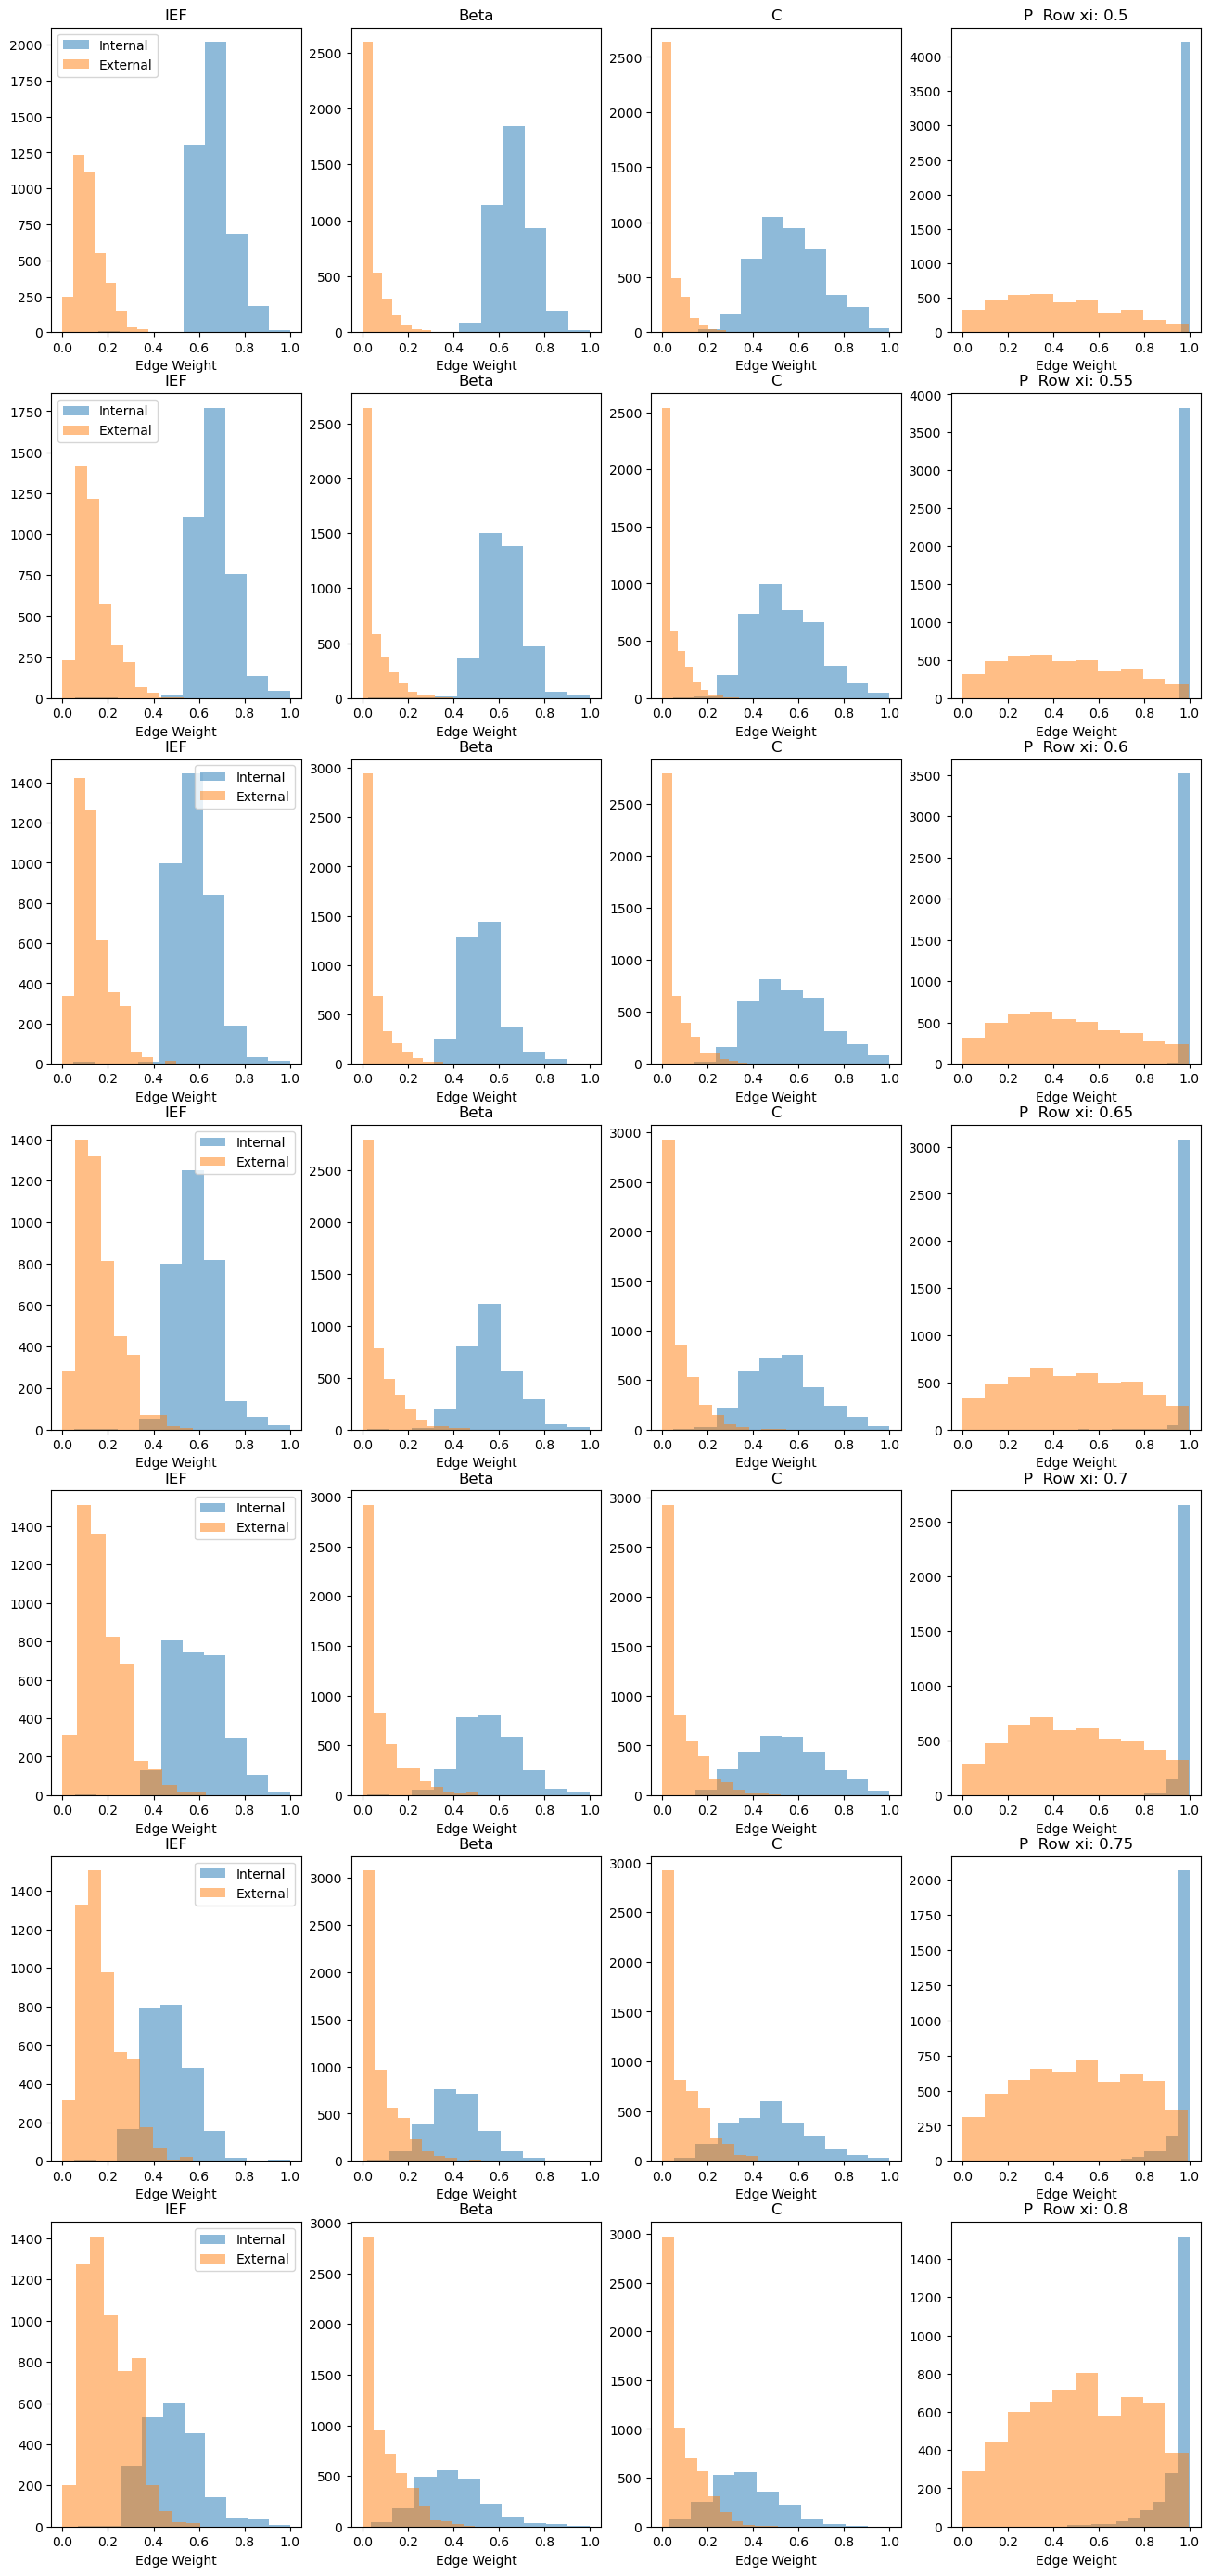

In [5]:
%%time
XIs = [.5, .55, .6, .65, .7, .75, .8]
fig, axs = plt.subplots(len(XIs), 4, figsize=(16, 5*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                            zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    gt = partition2sparse(g.vs["gt"])
    ief, beta, c, p = cas_edge_weights(g, gt)
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    axs[i,0].hist(ief[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 0].hist(ief[is_internal == False], label="External", alpha=0.5)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()

    axs[i, 1].hist(beta[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 1].hist(beta[is_internal == False], label="External", alpha=0.5)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("Beta")

    axs[i, 2].hist(c[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 2].hist(c[is_internal == False], label="External", alpha=0.5)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title("C")

    axs[i, 3].hist(p[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 3].hist(p[is_internal == False], label="External", alpha=0.5)
    axs[i, 3].set_xlabel("Edge Weight")
    axs[i, 3].set_title(f"P  Row xi: {xi}")


In [103]:
"""
%%time
XIs = [.5, .55, .6, .65, .7, .75, .8]
fig, axs = plt.subplots(len(XIs), 4, figsize=(16, 5*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                            zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    leiden = partition2sparse(g.community_leiden(resolution=0.01).membership)
    print(f"{leiden.shape[1]} communities found for xi = {xi}, true number is {np.max(g.vs['gt'])}")
    ief, beta, c, p = cas_edge_weights(g, leiden)
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    axs[i,0].hist(ief[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 0].hist(ief[is_internal == False], label="External", alpha=0.5)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()

    axs[i, 1].hist(beta[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 1].hist(beta[is_internal == False], label="External", alpha=0.5)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("Beta")

    axs[i, 2].hist(c[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 2].hist(c[is_internal == False], label="External", alpha=0.5)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title("C")

    axs[i, 3].hist(p[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 3].hist(p[is_internal == False], label="External", alpha=0.5)
    axs[i, 3].set_xlabel("Edge Weight")
    axs[i, 3].set_title(f"P  Row xi: {xi}")
"""

'\n%%time\nXIs = [.5, .55, .6, .65, .7, .75, .8]\nfig, axs = plt.subplots(len(XIs), 4, figsize=(16, 5*len(XIs)))\nfor i in trange(len(XIs)):\n    xi = XIs[i]\n    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, \n                            zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)\n\n    leiden = partition2sparse(g.community_leiden(resolution=0.01).membership)\n    print(f"{leiden.shape[1]} communities found for xi = {xi}, true number is {np.max(g.vs[\'gt\'])}")\n    ief, beta, c, p = cas_edge_weights(g, leiden)\n    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")\n\n    axs[i,0].hist(ief[is_internal == True], label="Internal", alpha=0.5)\n    axs[i, 0].hist(ief[is_internal == False], label="External", alpha=0.5)\n    axs[i, 0].set_xlabel("Edge Weight")\n    axs[i, 0].set_title("IEF")\n    axs[i, 0].legend()\n\n    axs[i, 1].hist(beta[is_internal == True], label="Internal", alpha=0.5)\n    axs[i, 1].

In [102]:
"""
%%time
XIs = [.5, .55, .6, .65, .7, .75, .8]
fig, axs = plt.subplots(len(XIs), 4, figsize=(16, 5*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                            zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    leiden = partition2sparse(g.community_leiden(resolution=0.1).membership)
    print(f"{leiden.shape[1]} communities found for xi = {xi}, true number is {np.max(g.vs['gt'])}")
    ief, beta, c, p = cas_edge_weights(g, leiden)
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    axs[i,0].hist(ief[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 0].hist(ief[is_internal == False], label="External", alpha=0.5)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()

    axs[i, 1].hist(beta[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 1].hist(beta[is_internal == False], label="External", alpha=0.5)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("Beta")

    axs[i, 2].hist(c[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 2].hist(c[is_internal == False], label="External", alpha=0.5)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title("C")

    axs[i, 3].hist(p[is_internal == True], label="Internal", alpha=0.5)
    axs[i, 3].hist(p[is_internal == False], label="External", alpha=0.5)
    axs[i, 3].set_xlabel("Edge Weight")
    axs[i, 3].set_title(f"P  Row xi: {xi}")
"""

'\n%%time\nXIs = [.5, .55, .6, .65, .7, .75, .8]\nfig, axs = plt.subplots(len(XIs), 4, figsize=(16, 5*len(XIs)))\nfor i in trange(len(XIs)):\n    xi = XIs[i]\n    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, \n                            zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)\n\n    leiden = partition2sparse(g.community_leiden(resolution=0.1).membership)\n    print(f"{leiden.shape[1]} communities found for xi = {xi}, true number is {np.max(g.vs[\'gt\'])}")\n    ief, beta, c, p = cas_edge_weights(g, leiden)\n    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")\n\n    axs[i,0].hist(ief[is_internal == True], label="Internal", alpha=0.5)\n    axs[i, 0].hist(ief[is_internal == False], label="External", alpha=0.5)\n    axs[i, 0].set_xlabel("Edge Weight")\n    axs[i, 0].set_title("IEF")\n    axs[i, 0].legend()\n\n    axs[i, 1].hist(beta[is_internal == True], label="Internal", alpha=0.5)\n    axs[i, 1].h

## Test if it does well using first_level louvain

100%|██████████| 5/5 [01:28<00:00, 17.70s/it]


CPU times: user 1min 5s, sys: 68 ms, total: 1min 5s
Wall time: 1min 28s


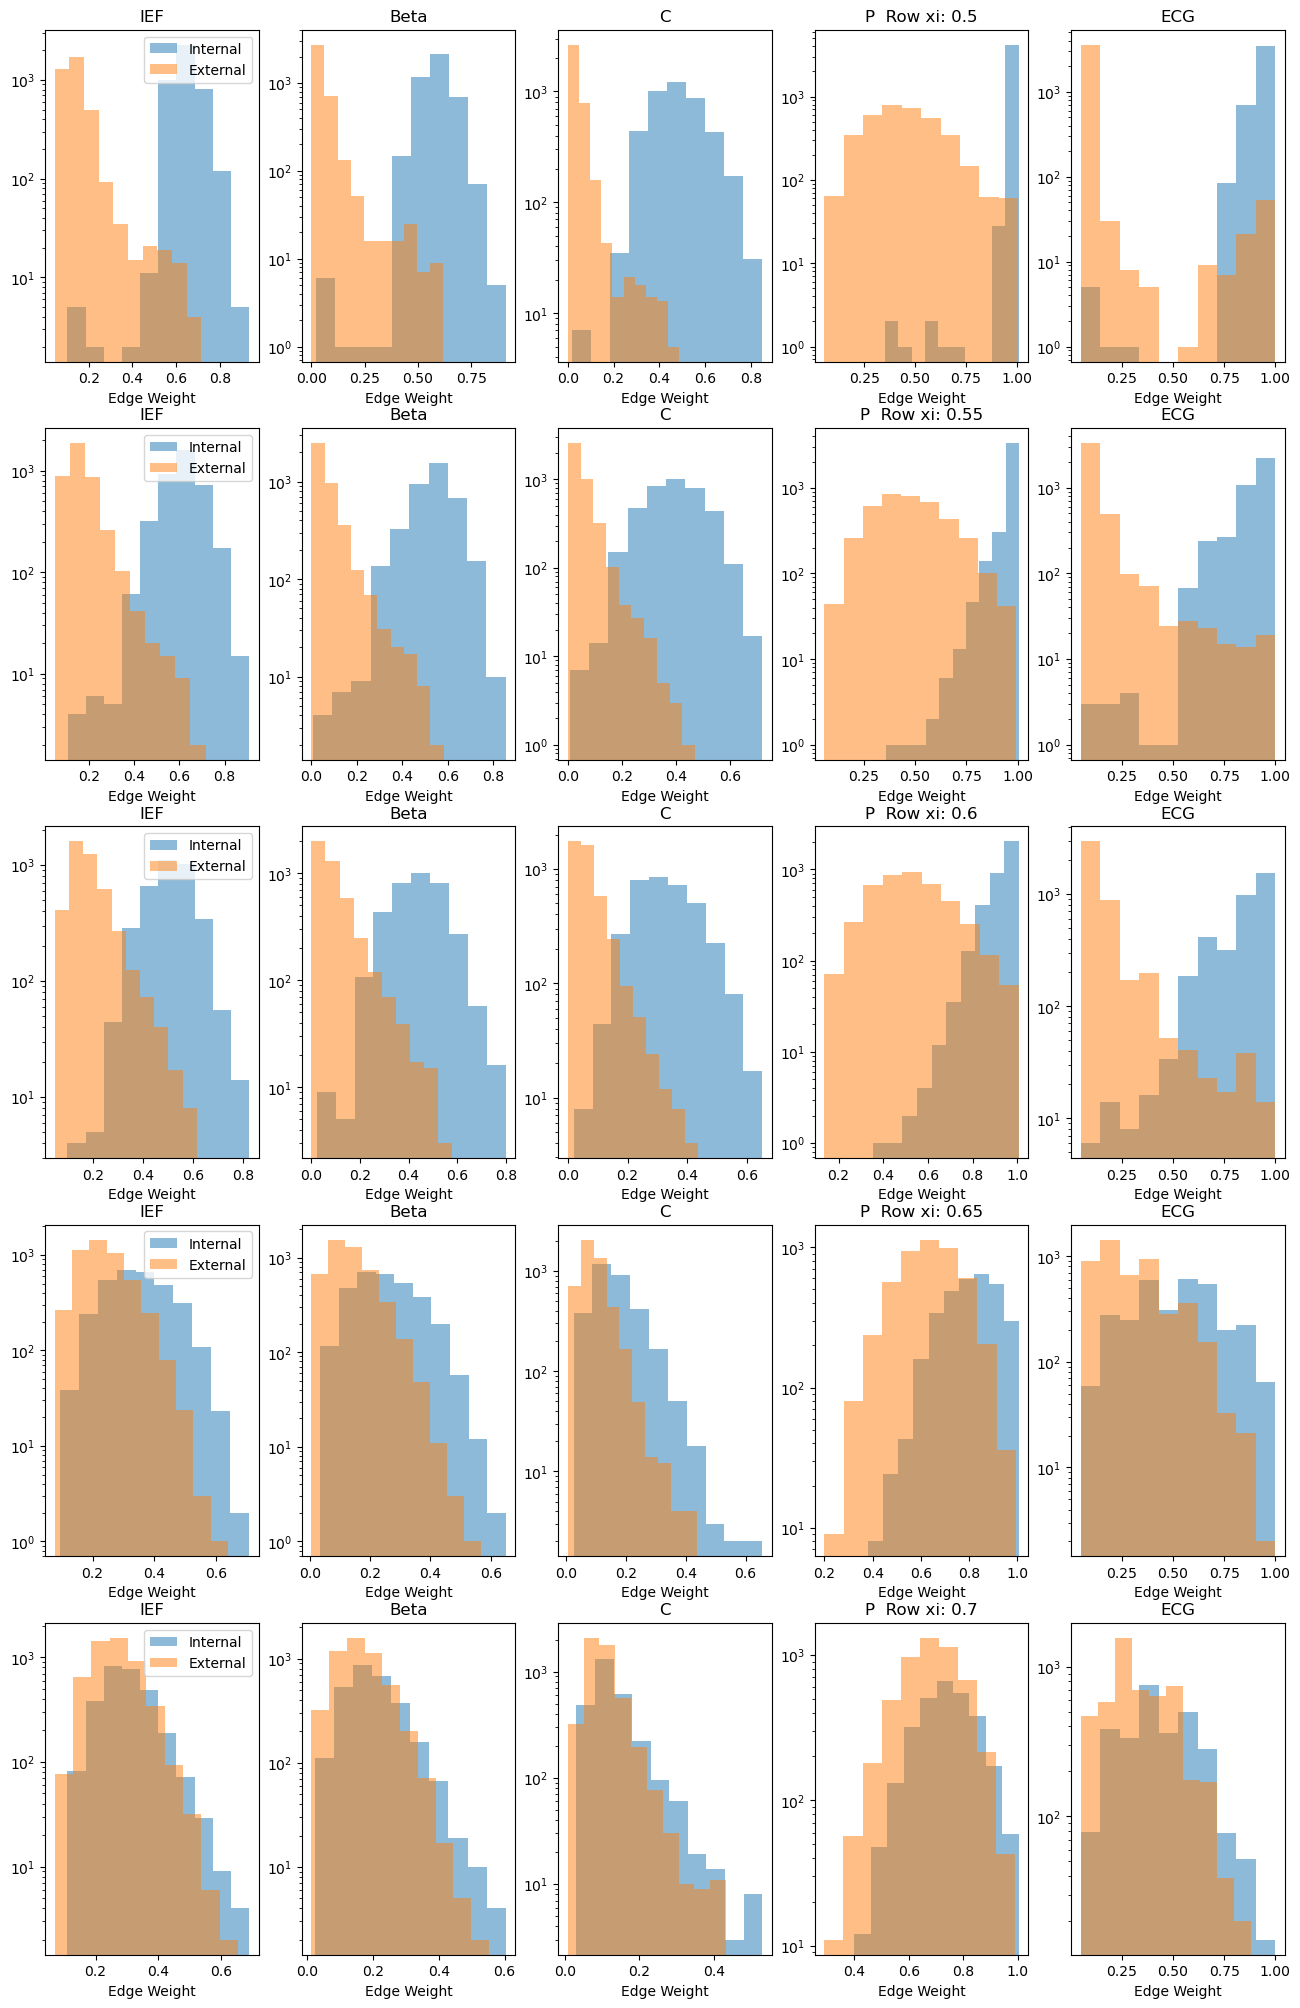

In [7]:
%%time
# Testing ensemble instead of one run

XIs = [.5, .55, .6, .65, .7]
fig, axs = plt.subplots(len(XIs), 5, figsize=(16, 5*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, 
                            zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)

    ief, beta, c, p = ensemble_cas_edge_weights(g, combine_function="min", resolution=0.05, clustering_method="first_louvain")
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    axs[i,0].hist(ief[is_internal == True], label="Internal", alpha=0.5, log=True)
    axs[i, 0].hist(ief[is_internal == False], label="External", alpha=0.5, log=True)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()

    axs[i, 1].hist(beta[is_internal == True], label="Internal", alpha=0.5, log=True)
    axs[i, 1].hist(beta[is_internal == False], label="External", alpha=0.5, log=True)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("Beta")

    axs[i, 2].hist(c[is_internal == True], label="Internal", alpha=0.5, log=True)
    axs[i, 2].hist(c[is_internal == False], label="External", alpha=0.5, log=True)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title("C")

    axs[i, 3].hist(p[is_internal == True], label="Internal", alpha=0.5, log=True)
    axs[i, 3].hist(p[is_internal == False], label="External", alpha=0.5, log=True)
    axs[i, 3].set_xlabel("Edge Weight")
    axs[i, 3].set_title(f"P  Row xi: {xi}")

    W = np.array(g.community_ecg().W)
    axs[i, 4].hist(W[is_internal == True], label="Internal", alpha=0.5, log=True)
    axs[i, 4].hist(W[is_internal == False], label="External", alpha=0.5, log=True)
    axs[i, 4].set_xlabel("Edge Weight")
    axs[i, 4].set_title(f"ECG")

## The Experiments

Use the CAS to predict wether an edge is intra-community or inter-community.
Similar to ECG, average this weight over several first step Louvain runs.
Basically weighting ECG belief with CAS instead of just 1-0 are in cluster.

In [42]:
g = _run_julia_abcd(xi=0.4)

clusters = g.community_multilevel(return_levels=True)[0].membership
cluster_matrix = partition2sparse(clusters)
graph_matrix = g.get_adjacency_sparse()
ief, beta, c, p, degs = CAS(graph_matrix, cluster_matrix)

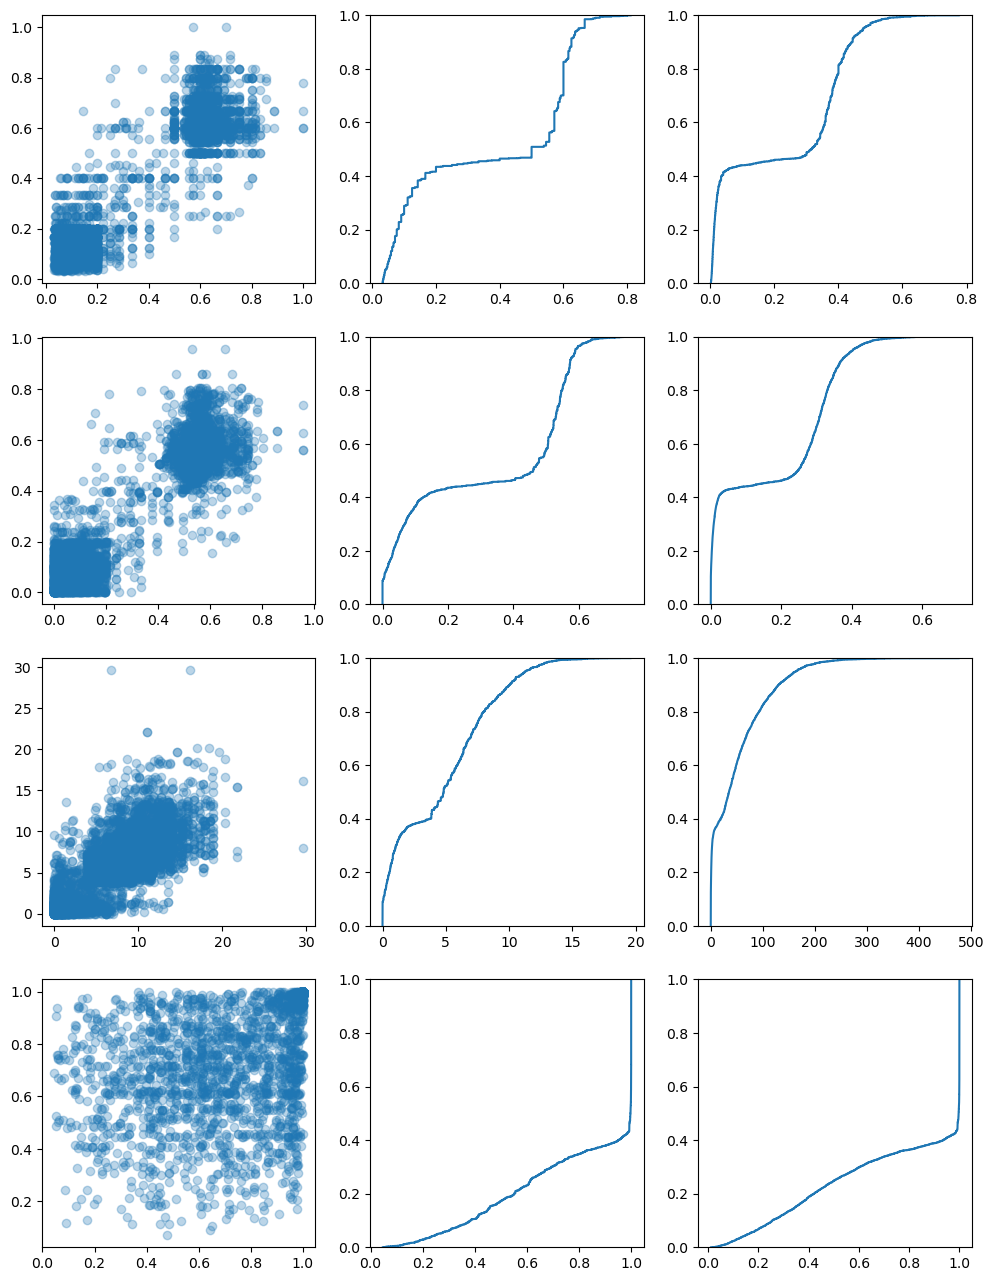

In [43]:
#Plotting potential edge weights
# First column is CAS x: e1 to the community of e2, y: e2 to the community of e1
# Second column is CDF-ish thing of taking the min value
# Thrid column is CDF-ish thing of x*y

fig, axs = plt.subplots(4, 3, figsize=(12,16))
for i, m in enumerate([ief, beta, c, p]):
    e1_to_e2 = np.array([m[e.source, clusters[e.target]] for e in g.es])
    e2_to_e1 = np.array([m[e.target, clusters[e.source]] for e in g.es])
    axs[i, 0].scatter(e1_to_e2, e2_to_e1, alpha=0.3)
    axs[i, 1].ecdf(np.minimum(e1_to_e2, e2_to_e1))
    axs[i, 2].ecdf(e1_to_e2*e2_to_e1)

In [44]:
ief, beta, c, p = ensemble_cas_edge_weights(g)

ief_cluster = cluster_edges(g, ief, resolution=0.01)
beta_cluster = cluster_edges(g, beta, final="louvain")
c_cluster = cluster_edges(g, c)
p_cluster = cluster_edges(g, p)

print("IEF ", AMI(ief_cluster.membership, g.vs["gt"]))
print("Beta", AMI(beta_cluster.membership, g.vs["gt"]))
print("C   ", AMI(c_cluster.membership, g.vs["gt"]))
print("P   ", AMI(p_cluster.membership, g.vs["gt"]))
print("ECG ", AMI(g.community_ecg().membership, g.vs["gt"]))

IEF  0.0
Beta 0.9640514279981006
C    0.9913597015785489
P    0.9874208265186205
ECG  0.995312409388021


## Some experiments on small ABCDo graphs

In [45]:
## first with "mid-size" graphs
XIs = [.5, .525, .55, .575, .6, .625, .65, .675, .7]
REP = 1
num_nodes = 1000
num_out = 0
delta = 10
min_comm = 100
alpha = 1

In [46]:
ens_size = 16
n_runs = 10

ief_min = np.empty((len(XIs), n_runs))
beta_min = np.empty((len(XIs), n_runs))
c_min = np.empty((len(XIs), n_runs))
p_min = np.empty((len(XIs), n_runs))
ief_prod = np.empty((len(XIs), n_runs))
beta_prod = np.empty((len(XIs), n_runs))
c_prod = np.empty((len(XIs), n_runs))
p_prod = np.empty((len(XIs), n_runs))
ecg = np.empty((len(XIs), n_runs))
leiden = np.empty((len(XIs), n_runs))


for i, xi in enumerate(XIs):
    for run in trange(n_runs):
        g = _run_julia_abcd(n=num_nodes, xi=xi, delta=delta, gamma=2.5, beta=1.5, zeta = 0.5, s=min_comm, tau = 0.767, nout=num_out)
        ief_weights, beta_weights, c_weights, p_weights = ensemble_cas_edge_weights(g, ens_size=ens_size, combine_function="min", clustering_method="first_louvain")
        ief_min[i, run] = AMI(cluster_edges(g, ief_weights).membership, g.vs["gt"])
        beta_min[i, run] = AMI(cluster_edges(g, beta_weights).membership, g.vs["gt"])
        c_min[i, run] = AMI(cluster_edges(g, c_weights).membership, g.vs["gt"])
        p_min[i, run] = AMI(cluster_edges(g, p_weights).membership, g.vs["gt"])

        ief_weights, beta_weights, c_weights, p_weights = ensemble_cas_edge_weights(g, ens_size=ens_size, combine_function="prod", clustering_method="first_louvain")
        ief_prod[i, run] = AMI(cluster_edges(g, ief_weights).membership, g.vs["gt"])
        beta_prod[i, run] = AMI(cluster_edges(g, beta_weights).membership, g.vs["gt"])
        c_prod[i, run] = AMI(cluster_edges(g, c_weights).membership, g.vs["gt"])
        p_prod[i, run] = AMI(cluster_edges(g, p_weights).membership, g.vs["gt"])

        ecg[i, run] = AMI(community_ecg(g, ens_size=ens_size, final="leiden").membership, g.vs["gt"])
        leiden[i, run] = AMI(g.community_leiden(objective_function='modularity').membership, g.vs["gt"])

100%|██████████| 10/10 [06:14<00:00, 37.43s/it]


Text(0.5, 1.0, 'ECG weighted with CAS clustering.')

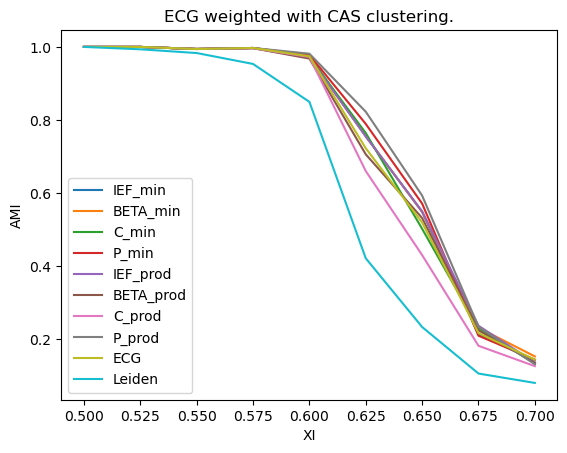

In [47]:
plt.plot(XIs, np.mean(ief_min, axis=1), label="IEF_min")
plt.plot(XIs, np.mean(beta_min, axis=1), label="BETA_min")
plt.plot(XIs, np.mean(c_min, axis=1), label="C_min")
plt.plot(XIs, np.mean(p_min, axis=1), label="P_min")

plt.plot(XIs, np.mean(ief_prod, axis=1), label="IEF_prod")
plt.plot(XIs, np.mean(beta_prod, axis=1), label="BETA_prod")
plt.plot(XIs, np.mean(c_prod, axis=1), label="C_prod")
plt.plot(XIs, np.mean(p_prod, axis=1), label="P_prod")

plt.plot(XIs, np.mean(ecg, axis=1), label="ECG")
plt.plot(XIs, np.mean(leiden, axis=1), label="Leiden")

plt.legend()
plt.xlabel("XI")
plt.ylabel("AMI")
plt.title("ECG weighted with CAS clustering.")